
# Capstone Project Overview


In [ ]:
#### Capstone Project: Predicting Technician Actions Using Failures based on Work Orders History ####

# This notebook walks through the process of:
# Cleaning real-world technician notes
# Labeling word clusters for similar behaviors from text
# Training ML models to predict technician actions based on past work order descriptions
# Goal: Assist maintenance teams with smart fix suggestions based on past patterns.

### WORKFLOW ###

# 1. Data management - Load and clean data (Drop rows with incomplete or irrelevant info)
# 2. System Labeling - NLP
# 3. Dimensionality Reduction (PCA/TSNE/UMAP for visuals)
# 4. Train/Test Split (X = description, y = solution/note)
# 5. Model Training: DT, RF, NN
# 6. Evaluation + Narrative Generation

# **1. Data Management**

# Imports & Installs

In [3]:
# --- One-time setup 
import sys, subprocess

def pip_install(pkg):
    try:
        __import__(pkg.split("[")[0].replace("-", "_"))
    except ImportError:
        print(f"Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

# (pip install)
pip_install("sentence-transformers")
pip_install("fuzzywuzzy[speedup]")
pip_install("groq")        
pip_install("openai")      


Installing sentence-transformers ...
Installing fuzzywuzzy[speedup] ...
Installing groq ...
Installing openai ...


In [41]:

# ===============================
# Core
# ===============================
!pip install umap-learn
import os, re, warnings
import numpy as np
!pip install pandas
import pandas as pd
import joblib
from tqdm import tqdm
warnings.filterwarnings("ignore")

# ===============================
# NLP / Vectorization
# ===============================
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# embedding baseline (semantic retrieval)
from sentence_transformers import SentenceTransformer

# fuzzy matching utility 
from fuzzywuzzy import fuzz

# ===============================
# Modeling (classification scope)
# ===============================
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# ===============================
# Metrics
# ===============================
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
)

# ===============================
# Visualization
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

# Dimensionality-reduction for visuals 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap  # This will now work after installing umap-learn

# ===============================
# LLM Clients (for narrative layer)
# ===============================
from groq import Groq        
from openai import OpenAI

In [7]:
!python -m spacy download en_core_web_sm
!pip install python-Levenshtein


C:\Users\John\anaconda3\python.exe: No module named spacy


# Cleaning Data

In [43]:



import os
df = pd.read_csv(os.path.join(os.path.expanduser("~"), "Downloads/cleaned_work_orders.csv"))

df = df.dropna(how='all')

# Drop noise in Data
df = df[~df['Text'].str.contains("completed", case=False, na=False)]
df = df[~df['Text'].str.contains("complete", case=False, na=False)]
df = df[~df['Text'].str.contains("mike", case=False, na=False)]
df = df[~df['Text'].str.contains("mike's", case=False, na=False)]
df = df[~df['Text'].str.contains("odd", case=False, na=False)]

df = df.dropna(subset=['Description', 'Text']).drop_duplicates()

# Keep only rows where WO No. is numeric
df = df[df['WO No.'].astype(str).str.match(r'^\d+$')]

# Strip spaces and standardize text fields
df['WO No.'] = df['WO No.'].astype(str).str.strip()
df['Description'] = df['Description'].astype(str).str.strip()
df['Text'] = df['Text'].astype(str).str.strip()

# Clean Description
df['Description_cleaned'] = (
    df['Description']
    .fillna("")
    .str.lower()
    .str.replace(r'[^\w\s]', '', regex=True)  # Remove punctuation
    .str.replace(r'\d+', '', regex=True)      # Remove digits
    .str.strip()
)

# Clean Technician Text Notes
df['Text_cleaned'] = (
    df['Text']
    .fillna("")
    .str.lower()
    .str.replace(r'[^\w\s]', '', regex=True)
    .str.replace(r'\d+', '', regex=True)
    .str.strip()
)

# Keep rows where both sides exist and are not trivial
df = df[['Description_cleaned', 'Text_cleaned']].dropna()
df = df[df['Description_cleaned'].str.strip() != ""]
df = df[df['Text_cleaned'].str.strip() != ""]

# Filter out rows with completely blank descriptions and notes
df = df[~((df['Description_cleaned'].str.strip() == "") & (df['Text_cleaned'].str.strip() == ""))]

# Ensure valid technician notes
df = df[df['Text_cleaned'].notna() & (df['Text_cleaned'].str.strip() != "") & (df['Text_cleaned'].str.lower().str.strip() != "nan")]

# Show data sample for verification
display(df[['Description_cleaned', 'Text_cleaned']].head())

Description_cleaned  \
9                                             cushion   
11  take out section of conveyor on vertical oven ...   
12                                          stop time   
13          remove gas meter from solder pour machine   
23                        check bearings making noise   

                                         Text_cleaned  
9     checking on a new controller ordered controller  
11                        took out about  ft of chain  
12  press was in a wierd position causing the disc...  
13   removed gas meter and installed replacement pipe  
23                                    problem stopped

# **2. System Labeling**

In [45]:
# Map free-text notes to a small, useful label set.

# --- 1) Primary rule-based mapping ---
ACTION_PATTERNS = [
    ("Replace Part",   r"\b(replace|replaced|swap|swapped|install(ed)?)\b.*\b(bearing|motor|belt|gear|fuse|sensor|valve|hose|coupling|chain|switch|roller|pulley|seal)\b"),
    ("Tighten/Adjust", r"\b(tighten|tightened|adjust|adjusted|align|aligned|re-seat|reseat|calibrate|calibrated|reposition|realign(ed)?)\b"),
    ("Clean/Clear",    r"\b(clean|cleaned|clear|cleared|remove|removed)\b.*\b(debris|dust|jam|blockage|clog)\b|\b(cleaned|cleared)\b"),
    ("Refill/Top Off", r"\b(add|added|refill|refilled|top\s?off)\b.*\b(oil|fluid|grease|lub(e|ricant)|coolant)\b"),
    ("Electrical Fix", r"\b(replace|replaced|reset|rewire|wire(d)?|reconnect|connector|contactor|breaker|fuse|vfd|plc|relay)\b"),
    ("Hydraulic/Pneumatic Fix", r"\b(hose|cylinder|solenoid|regulator|air line|hydraulic|pneumatic)\b.*\b(repair|replace|fixed|leak|leaking)\b"),
    ("Reset/Power Cycle", r"\b(reset|power.?cycle|cycled|restart|reboot|restarted)\b"),
    ("Inspection/Test Only", r"\b(inspect|inspected|tested|verify|verified|checked)\b(?!.*replace|.*repair|.*fix)"),
    ("Other", r".*")
]

import re

def to_response_label(text: str) -> str:
    t = " " + str(text).lower() + " "
    for label, pat in ACTION_PATTERNS:
        if re.search(pat, t):
            return label
    return "Other"

df['Response_Label'] = df['Text_cleaned'].apply(to_response_label)


# --- 2) Secondary re-mapping for rows still tagged "Other" ---
# Uses precise bigrams first, then high-signal unigrams, mapped into EXISTING labels only.

BIGRAM_MAP = [
    # Installation / replacement
    (["installed new", "fabricated new", "changed torch", "removed broken"], "Replace Part"),

    # Pneumatic / hydraulic
    (["air line", "air pressure", "air leak", "solenoid valve", "foot pedal"], "Hydraulic/Pneumatic Fix"),

    # Electrical
    (["limit switch", "power supply", "light curtain", "repaired wiring"], "Electrical Fix"),

    # Inspection / test outcomes
    (["started working", "went away", "working ok", "worked fine", "ran fine"], "Inspection/Test Only"),

    # Mechanical tighten/adjust
    (["came loose", "took apart"], "Tighten/Adjust"),
]

UNIGRAM_MAP = [
    # Installation / replacement
    (["installed", "install", "changed", "removed", "new"], "Replace Part"),

    # Pneumatic / hydraulic
    (["air", "line", "hose", "pump", "cylinder", "solenoid", "regulator"], "Hydraulic/Pneumatic Fix"),

    # Electrical
    (["switch", "wiring", "controller", "power", "fuse"], "Electrical Fix"),

    # Inspection / test / ambiguous OK
    (["found", "checked", "ok", "not working", "problem"], "Inspection/Test Only"),

    # Mechanical adjust
    (["loose", "aligned", "adjust", "tighten", "tightened"], "Tighten/Adjust"),
]

def remap_other_label(note: str) -> str:
    t = str(note).lower()

    # 1) Bigram priority (exact substring search for speed/clarity)
    for phrases, mapped in BIGRAM_MAP:
        if any(p in t for p in phrases):
            return mapped

    # 2) Unigram fallbacks
    for terms, mapped in UNIGRAM_MAP:
        if any(w in t for w in terms):
            return mapped

    return "Other"

mask_other = (df["Response_Label"] == "Other")
df.loc[mask_other, "Response_Label"] = df.loc[mask_other, "Text_cleaned"].apply(remap_other_label)


# --- 3) Collapse tiny labels again (keeps classes trainable) ---
min_count = 15
vc = df['Response_Label'].value_counts()
valid = vc[vc >= min_count].index
df.loc[~df['Response_Label'].isin(valid), 'Response_Label'] = "Other"

# new distribution to confirm "Other" 
print("Label distribution AFTER re-map:\n", df['Response_Label'].value_counts())



Label distribution AFTER re-map:
 Response_Label
Electrical Fix             14487
Other                       9822
Replace Part                8775
Tighten/Adjust              5862
Hydraulic/Pneumatic Fix     3718
Inspection/Test Only        3388
Clean/Clear                 3170
Reset/Power Cycle            226
Refill/Top Off               211
Name: count, dtype: int64


# **3. Dimensionality Reduction (PCA/TSNE/UMAP for visuals)**

# PCA

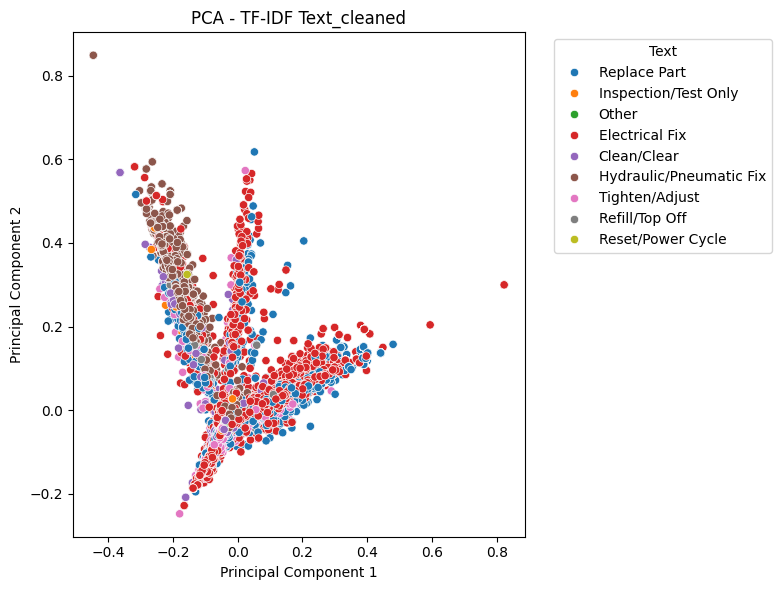

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer # Ensure TfidfVectorizer is imported if not globally available

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = tfidf.fit_transform(df['Text_cleaned'].fillna(''))
y = df['Response_Label']

# Use sklearn's PCA explicitly
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='tab10')
plt.title("PCA - TF-IDF Text_cleaned")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Text', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# TSNE

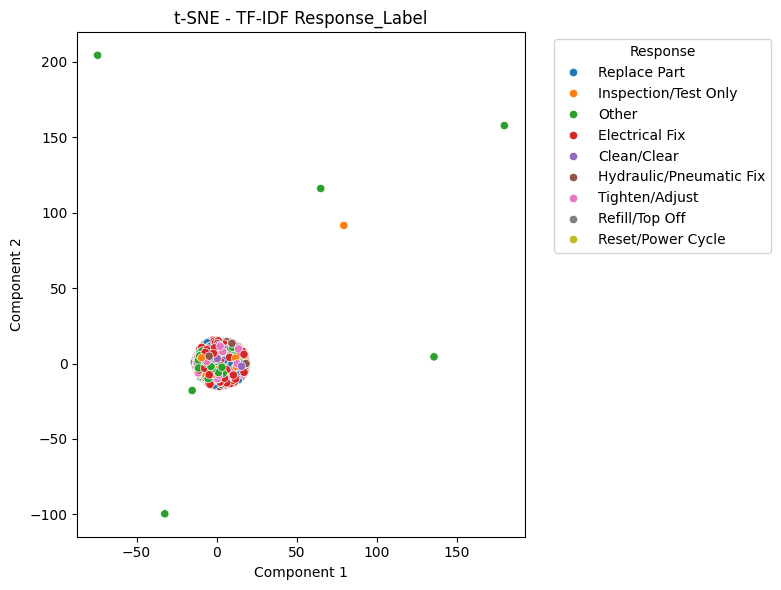

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
X_tsne = tsne.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='tab10')
plt.title("t-SNE - TF-IDF Response_Label")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title='Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# UMAP

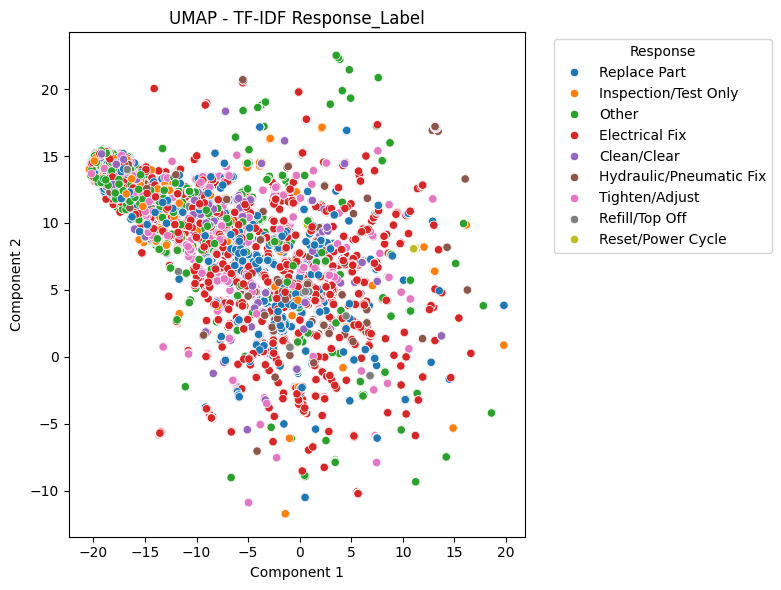

In [ ]:
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_tfidf)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='tab10')
plt.title("UMAP - TF-IDF Response_Label")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title='Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Saving visual artifacts to: /content/drive/MyDrive/MainXance/vis_artifacts
Running PCA(2)…


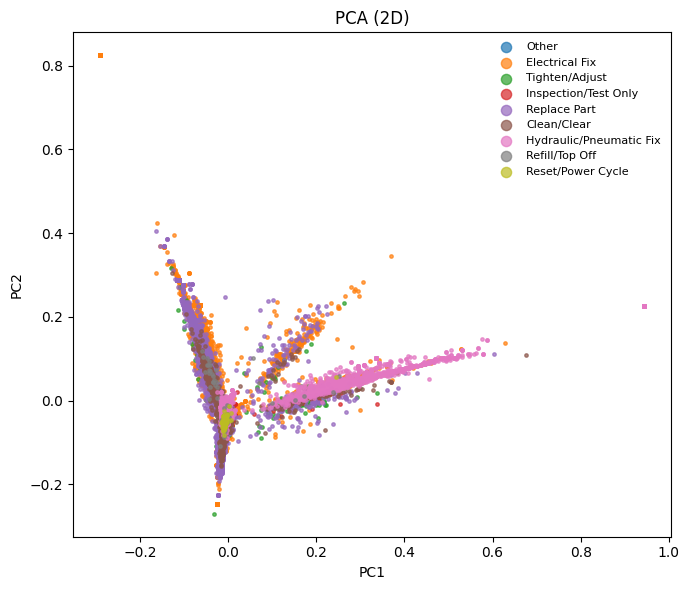

Running t-SNE(2)… (subsample if needed)


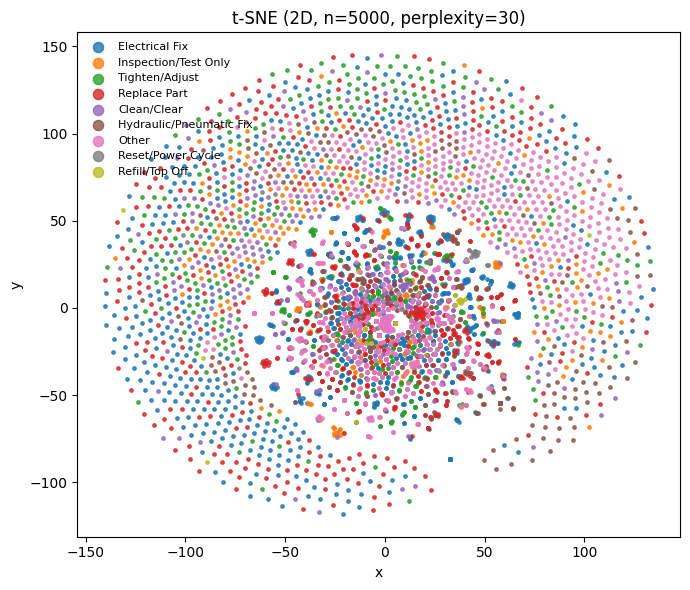

Running UMAP(2)… (subsample if needed)


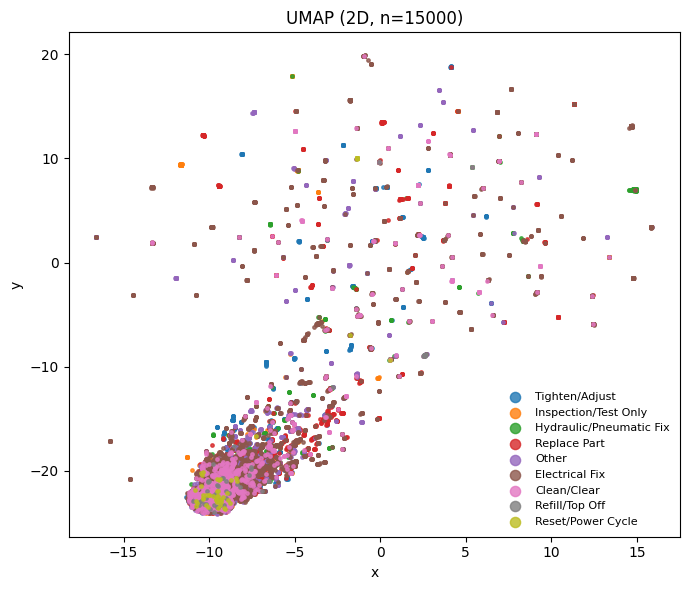

Done. Files written to: /content/drive/MyDrive/MainXance/vis_artifacts


In [ ]:
# ==== Save PCA / t-SNE / UMAP artifacts & plots ====
import numpy as np, pandas as pd, joblib, time
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# y labels for coloring
try:
    y_labels = y_train_text.astype(str).reset_index(drop=True)
except Exception:
    y_labels = None

# Helper: convert to dense float32 safely
def to_dense_float32(X):
    if hasattr(X, "toarray"):
        X = X.toarray()
    X = np.asarray(X)
    if X.dtype != np.float32:
        X = X.astype(np.float32, copy=False)
    return X

# Use the TRAIN matrix you clustered/classified on
assert 'X_train' in globals(), "X_train_vec not found. Provide your train feature matrix."
Xmat_full = X_train
n = Xmat_full.shape[0]

# Subsample for heavy methods to keep plots readable/fast
MAX_TSNE = 5000
MAX_UMAP = 15000
rng = np.random.RandomState(42)

def subsample(X, y, k):
    if X.shape[0] <= k:
        return X, y, np.arange(X.shape[0])
    idx = rng.choice(X.shape[0], k, replace=False)
    if y is not None:
        return X[idx], y.iloc[idx].reset_index(drop=True), idx
    return X[idx], None, idx

# ---------- PCA (fast, saves model + coords + plot) ----------
print("Running PCA(2)…")
Xp = to_dense_float32(Xmat_full)
pca = PCA(n_components=2, random_state=42)
P_pca = pca.fit_transform(Xp)

# Plot PCA
plt.figure(figsize=(7,6))
if y_labels is not None:
    # basic coloring by label
    for lab in pd.Series(y_labels).unique():
        m = (y_labels == lab).values
        plt.scatter(P_pca[m,0], P_pca[m,1], s=6, alpha=0.7, label=str(lab))
    plt.legend(markerscale=3, fontsize=8, frameon=False)
else:
    plt.scatter(P_pca[:,0], P_pca[:,1], s=6, alpha=0.7)
plt.title("PCA (2D)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

# ---------- t-SNE (coords + plot; no reusable model) ----------
print("Running t-SNE(2)… (subsample if needed)")
Xts, yts, idx_ts = subsample(Xp, y_labels, MAX_TSNE)

# Pick a sane perplexity relative to sample size
perp = max(5, min(30, (Xts.shape[0] - 1) // 3))
tsne = TSNE(n_components=2, perplexity=perp, learning_rate="auto",
            init="pca", n_iter=1000, random_state=42, verbose=0)
P_tsne = tsne.fit_transform(Xts)

# ---------- UMAP (saves model + coords + plot, if available) ----------
print("Running UMAP(2)… (subsample if needed)")
HAS_UMAP = False
try:
    import umap.umap_ as umap
    HAS_UMAP = True
except Exception:
    pass

if HAS_UMAP:
    Xum, yum, idx_um = subsample(Xp, y_labels, MAX_UMAP)
    um = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric="euclidean",
        random_state=42,
        verbose=False,
    )
    P_umap = um.fit_transform(Xum)

    # Save UMAP model & coords
    joblib.dump(um, SAVE_DIR / "umap_2d.joblib")
    pd.DataFrame({
        "umap_x": P_umap[:,0],
        "umap_y": P_umap[:,1],
        "label": yum if yum is not None else None,
        "orig_index": idx_um
    }).to_csv(SAVE_DIR / "umap_2d_coords.csv", index=False)

    # Plot UMAP
    plt.figure(figsize=(7,6))
    if yum is not None:
        for lab in pd.Series(yum).unique():
            m = (yum == lab).values
            plt.scatter(P_umap[m,0], P_umap[m,1], s=6, alpha=0.8, label=str(lab))
        plt.legend(markerscale=3, fontsize=8, frameon=False)
    else:
        plt.scatter(P_umap[:,0], P_umap[:,1], s=6, alpha=0.8)
    plt.title(f"UMAP (2D, n={Xum.shape[0]})")
    plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout(); plt.show()
else:
    print("UMAP not installed; skipped. Install with: pip install umap-learn")

print("Done. Files written to:", SAVE_DIR.resolve())

# Sentence Transformer


In [19]:
# Load the SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define features and labels
X = model.encode(df['Description_cleaned'].tolist(), show_progress_bar=True)
y = df['Response_Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1552 [00:00<?, ?it/s]

In [20]:
# Set up features and labels
X_embed = model.encode(df['Description_cleaned'].tolist(), show_progress_bar=True)
X = X_embed
y = df['Response_Label']

Batches:   0%|          | 0/1552 [00:00<?, ?it/s]

# **4. Split Train & Test**

In [46]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from collections import Counter
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize 
vectorizer = TfidfVectorizer(stop_words='english', max_features=8000, min_df=3)
X = vectorizer.fit_transform(df['Description_cleaned'].astype(str))
y = df['Response_Label'].astype(str)

# Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


# Dimensionality reduction 
svd = TruncatedSVD(n_components=150, random_state=42)
X_dense = svd.fit_transform(X)  

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_dense, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# SMOTE on dense features
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Original class counts:", Counter(y))
print("Train (encoded) before:", Counter(y_train))
print("Train (encoded) after :", Counter(y_train_res))


Original class counts: Counter({'Electrical Fix': 14487, 'Other': 9822, 'Replace Part': 8775, 'Tighten/Adjust': 5862, 'Hydraulic/Pneumatic Fix': 3718, 'Inspection/Test Only': 3388, 'Clean/Clear': 3170, 'Reset/Power Cycle': 226, 'Refill/Top Off': 211})
Train (encoded) before: Counter({np.int64(1): 11589, np.int64(4): 7858, np.int64(6): 7020, np.int64(8): 4690, np.int64(2): 2974, np.int64(3): 2710, np.int64(0): 2536, np.int64(7): 181, np.int64(5): 169})
Train (encoded) after : Counter({np.int64(4): 11589, np.int64(0): 11589, np.int64(8): 11589, np.int64(1): 11589, np.int64(3): 11589, np.int64(6): 11589, np.int64(2): 11589, np.int64(5): 11589, np.int64(7): 11589})


# Training Prep

In [47]:
# Convert to numpy for sklearn
X_embed_np = np.array(X_embed)

# Prepare target labels (supervised)
y = df['Response_Label'].reset_index(drop=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_embed_np, y, test_size=0.2, stratify=y, random_state=42)

# Train classifier
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# 8. Evaluate
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


                         precision    recall  f1-score   support

            Clean/Clear       0.34      0.04      0.07       634
         Electrical Fix       0.37      0.72      0.49      2898
Hydraulic/Pneumatic Fix       0.31      0.06      0.11       744
   Inspection/Test Only       0.18      0.01      0.02       678
                  Other       0.44      0.45      0.44      1964
         Refill/Top Off       0.00      0.00      0.00        42
           Replace Part       0.34      0.23      0.27      1755
      Reset/Power Cycle       0.00      0.00      0.00        45
         Tighten/Adjust       0.32      0.25      0.28      1172

               accuracy                           0.38      9932
              macro avg       0.25      0.20      0.19      9932
           weighted avg       0.35      0.38      0.33      9932



# **5. Modeling**

# ML Pipeline Cross-Validation

In [61]:
# ==== Lean model comparison (TF-IDF inside pipelines) ====
import numpy as np, pandas as pd
from collections import OrderedDict
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# ---- XGBoost (will skip if not installed) ----
try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# ===== Data =====
X_text = df["Description_cleaned"].astype(str).values
y_text = df["Response_Label"].astype(str).values

# Encode labels once (needed for XGBoost; OK for others too)
le = LabelEncoder()
y = le.fit_transform(y_text)

# ===== CV setup =====
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
tfidf = TfidfVectorizer(stop_words="english", max_features=6000, ngram_range=(1,2), min_df=3)

# ===== Pipelines =====
models = OrderedDict()

models["NaiveBayes"] = Pipeline([
    ("tfidf", tfidf),
    ("clf", MultinomialNB(alpha=0.5))
])

models["LogReg"] = Pipeline([
    ("tfidf", tfidf),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear"))
])

models["DecisionTree"] = Pipeline([
    ("tfidf", tfidf),
    ("clf", DecisionTreeClassifier(max_depth=18, min_samples_leaf=3, random_state=42))
])

models["RandomForest"] = Pipeline([
    ("tfidf", tfidf),
    ("clf", RandomForestClassifier(
        n_estimators=200, max_depth=18, min_samples_leaf=2,
        class_weight="balanced_subsample", n_jobs=-1, random_state=42))
])

if HAS_XGB:
    models["XGBoost"] = Pipeline([
        ("tfidf", tfidf),
        ("clf", xgb.XGBClassifier(
            objective="multi:softprob",
            num_class=len(np.unique(y)),
            n_estimators=400, max_depth=8, learning_rate=0.2,
            subsample=0.8, colsample_bytree=0.8,
            tree_method="hist", eval_metric="mlogloss",
            n_jobs=-1, random_state=42))
    ])

# ===== Cross-validation (macro-F1 + accuracy) =====
rows = []
for name, pipe in models.items():
    f1 = cross_val_score(pipe, X_text, y, cv=cv, scoring="f1_macro", n_jobs=-1)
    acc = cross_val_score(pipe, X_text, y, cv=cv, scoring="accuracy", n_jobs=-1)
    rows.append({
        "model": name,
        "cv_f1_macro_mean": f1.mean(),
        "cv_f1_macro_std": f1.std(),
        "cv_accuracy_mean": acc.mean(),
        "cv_accuracy_std": acc.std()
    })

res = pd.DataFrame(rows).sort_values("cv_f1_macro_mean", ascending=False).reset_index(drop=True)
print("=== Cross-validated results (3-fold, stratified) ===")
display(res)

# =====  Fit the top model on a proper train/test split and report test metrics =====
top_model_name = res.iloc[0]["model"]
print(f"\nTraining top model on a hold-out split: {top_model_name}")

# split raw text (no leakage), then fit pipeline on train, evaluate on test
X_tr_text, X_te_text, y_tr, y_te = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

pipe = models[top_model_name]
pipe.fit(X_tr_text, y_tr)

y_pred = pipe.predict(X_te_text)
print("\n=== Test set metrics (hold-out) ===")
print("Accuracy:", f"{accuracy_score(y_te, y_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_te, y_pred, target_names=le.classes_, digits=3))


=== Cross-validated results (3-fold, stratified) ===


model  cv_f1_macro_mean  cv_f1_macro_std  cv_accuracy_mean  \
0        LogReg          0.247033         0.002223          0.331904   
1    NaiveBayes          0.202568         0.000207          0.381723   
2  RandomForest          0.167917         0.006987          0.208663   
3  DecisionTree          0.128770         0.001017          0.335508   

   cv_accuracy_std  
0         0.001285  
1         0.001382  
2         0.007782  
3         0.000289


Training top model on a hold-out split: LogReg

=== Test set metrics (hold-out) ===
Accuracy: 0.340

Classification Report:
                         precision    recall  f1-score   support

            Clean/Clear      0.192     0.235     0.211       634
         Electrical Fix      0.497     0.410     0.449      2898
Hydraulic/Pneumatic Fix      0.235     0.319     0.271       744
   Inspection/Test Only      0.114     0.147     0.128       678
                  Other      0.505     0.373     0.429      1964
         Refill/Top Off      0.058     0.405     0.102        42
           Replace Part      0.382     0.280     0.323      1755
      Reset/Power Cycle      0.025     0.222     0.044        45
         Tighten/Adjust      0.316     0.389     0.348      1172

               accuracy                          0.340      9932
              macro avg      0.258     0.309     0.256      9932
           weighted avg      0.388     0.340     0.357      9932



# Naive Bayes


=== Naive Bayes (TF-IDF) — Test ===
                         precision    recall  f1-score   support

            Clean/Clear      0.507     0.043     0.079       792
         Electrical Fix      0.374     0.778     0.505      3622
Hydraulic/Pneumatic Fix      0.451     0.055     0.098       929
   Inspection/Test Only      0.257     0.011     0.020       847
                  Other      0.464     0.404     0.432      2456
         Refill/Top Off      0.000     0.000     0.000        53
           Replace Part      0.343     0.238     0.281      2194
      Reset/Power Cycle      0.000     0.000     0.000        56
         Tighten/Adjust      0.342     0.233     0.277      1466

               accuracy                          0.384     12415
              macro avg      0.304     0.196     0.188     12415
           weighted avg      0.385     0.384     0.329     12415

Macro AP (fallback): 0.228


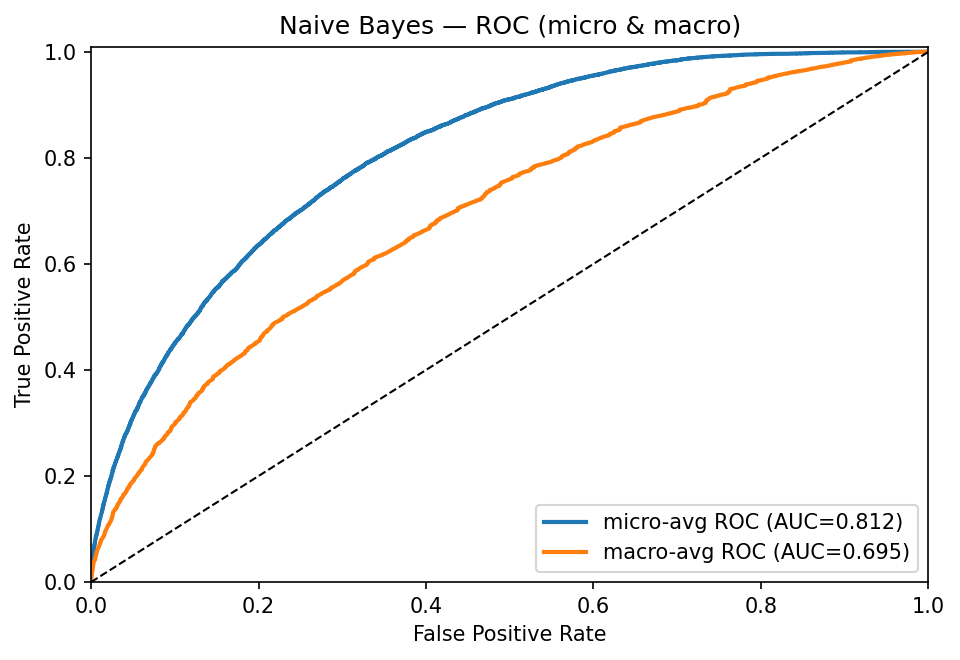

In [64]:
# === Naive Bayes (TF-IDF)  ===
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
import joblib


# 1) Train pipeline (TF-IDF -> Naive Bayes)
pipe_nb = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=5000)),
    ("clf", MultinomialNB(alpha=0.5))
])
pipe_nb.fit(X_train_text, y_train)

# 2) Predictions
y_nb = pipe_nb.predict(X_test_text)

print("\n=== Naive Bayes (TF-IDF) — Test ===")
print(classification_report(y_test, y_nb, digits=3))


# Per-class PR/Recall/F1 bars (if helper exists)
try:
    plot_prf_bars(prf_table(y_test, y_nb), "Naive Bayes — Precision/Recall/F1")
except Exception:
    pass  # skip gracefully if helpers not defined

# 3) Macro Precision–Recall curve (model has predict_proba)
try:
    macro_pr_curve(pipe_nb, X_test_text, y_test)
except Exception:
    # minimal fallback: macro AP only
    classes = sorted(np.unique(y_test))
    Y = label_binarize(y_test, classes=classes)
    P = pipe_nb.predict_proba(X_test_text)
    aps = [average_precision_score(Y[:,k], P[:,k]) for k in range(Y.shape[1])]
    print(f"Macro AP (fallback): {np.mean(aps):.3f}")

# 4) Multiclass ROC — macro & micro (clean, no per-class clutter)
classes = sorted(np.unique(y_test))
Y = label_binarize(y_test, classes=classes)         # shape: N x K
P = pipe_nb.predict_proba(X_test_text)              # shape: N x K

# Micro-average ROC
fpr_micro, tpr_micro, _ = roc_curve(Y.ravel(), P.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

# Macro-average ROC
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(Y.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(Y[:, i], P[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Aggregate macro
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(Y.shape[1])]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(Y.shape[1]):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= Y.shape[1]
auc_macro = auc(all_fpr, mean_tpr)

plt.figure(figsize=(6.5, 4.5), dpi=150)
plt.plot(fpr_micro, tpr_micro, lw=2, label=f"micro-avg ROC (AUC={auc_micro:.3f})")
plt.plot(all_fpr,   mean_tpr,  lw=2, label=f"macro-avg ROC (AUC={auc_macro:.3f})")
plt.plot([0,1], [0,1], "k--", lw=1)
plt.title("Naive Bayes — ROC (micro & macro)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.xlim(0,1); plt.ylim(0,1.01); plt.legend(loc="lower right"); plt.tight_layout(); plt.show()


# Random Forest Classifier

Accuracy: 0.9487
                         precision    recall  f1-score   support

            Clean/Clear       0.96      0.99      0.97       634
         Electrical Fix       0.96      0.97      0.97      2898
Hydraulic/Pneumatic Fix       0.97      0.93      0.95       744
   Inspection/Test Only       0.92      0.80      0.85       678
                  Other       0.93      1.00      0.96      1964
         Refill/Top Off       0.97      0.74      0.84        42
           Replace Part       0.94      0.92      0.93      1755
      Reset/Power Cycle       1.00      0.71      0.83        45
         Tighten/Adjust       0.95      0.96      0.95      1172

               accuracy                           0.95      9932
              macro avg       0.96      0.89      0.92      9932
           weighted avg       0.95      0.95      0.95      9932



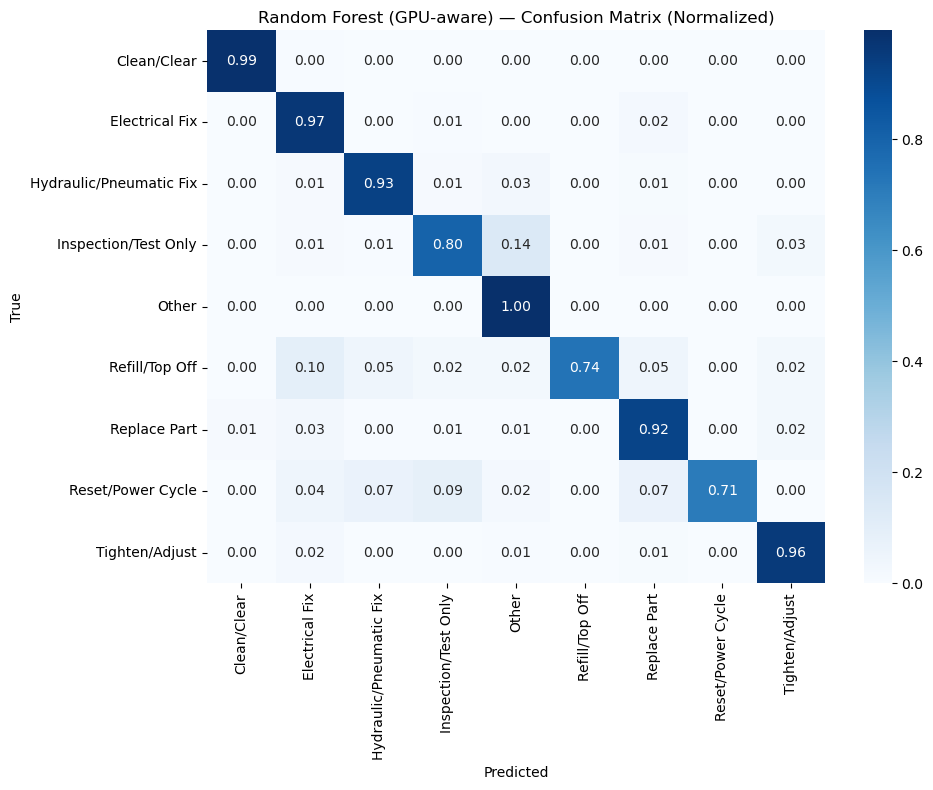

In [29]:
import numpy as np
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

TEXT_COL  = "Text_cleaned"
LABEL_COL = "Response_Label"

# Prepare data
mask = df[LABEL_COL].notna()
X_text = df.loc[mask, TEXT_COL].astype(str)
y_text = df.loc[mask, LABEL_COL].astype(str)

X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    X_text, y_text, test_size=0.2, random_state=42, stratify=y_text
)

# Vectorize → dense float32
tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=5000)
X_train = tfidf.fit_transform(X_train_text)

X_test  = tfidf.transform(X_test_text)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train_text)
y_test  = le.transform(y_test_text)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Metrics back in original label space
y_pred_labels = le.inverse_transform(y_pred)
print("Accuracy:", f"{accuracy_score(y_test_text, y_pred_labels):.4f}")
print(classification_report(y_test_text, y_pred_labels))

# Confusion matrix (normalized)
all_labels = sorted(le.classes_)
cm = confusion_matrix(y_test_text, y_pred_labels, labels=all_labels)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=all_labels, yticklabels=all_labels)
plt.title("Random Forest — Confusion Matrix (Normalized)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

# Decision Tree Classifier

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.9430


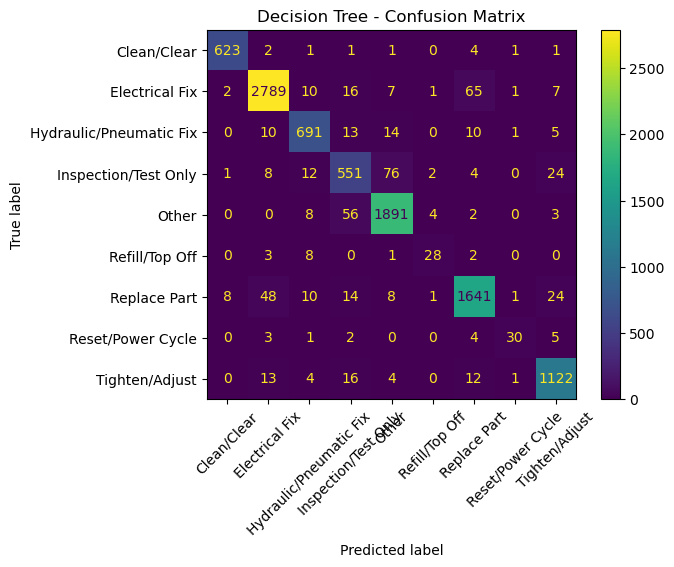

In [52]:
# Create a mask for non-null response labels
mask = df['Response_Label'].notna()

# Check if we need to process the text data
if 'X_train' not in locals() or 'X_test' not in locals():
    X_text = df.loc[mask, 'Text_cleaned'].astype(str)
    y_text = df.loc[mask, 'Response_Label'].astype(str)

    # Split data
    X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
        X_text, y_text, test_size=0.2, random_state=42, stratify=y_text
    )

    # Vectorize TF-IDF
    tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=5000)
    X_train = tfidf.fit_transform(X_train_text).toarray()
    X_test  = tfidf.transform(X_test_text).toarray()

    # Encode labels
    y_train = le.fit_transform(y_train_text)
    y_test = le.transform(y_test_text)
else:
    # If X_train, X_test, y_train, y_test are already defined (e.g., from SentenceTransformer)
    # Ensure y_train and y_test are encoded using the same label encoder
    all_labels = np.concatenate([y_train, y_test])
    le.fit(all_labels)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)


# Define hyperparameter grid
params = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# Initialize base model
dt = DecisionTreeClassifier(random_state=42)

# Perform grid search with 3-fold cross-validation
grid = GridSearchCV(dt, param_grid=params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Best model
best_dt_model = grid.best_estimator_

# Predict using the best model
y_pred_dt = best_dt_model.predict(X_test)

# Evaluate
print("Best Hyperparameters:", grid.best_params_)
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")

# Visualize confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, xticks_rotation=45, display_labels=le.classes_)
plt.title("Decision Tree - Confusion Matrix")
plt.show()

# Testing model for Overfitting

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Split data 
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['Text_cleaned'], 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# TF-IDF: fit only on the training text
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)


# Baseline check

In [54]:
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score

dum = DummyClassifier(strategy="most_frequent")
dum.fit(X_train, y_train)
y_base = dum.predict(X_test)
print("Baseline (most frequent) — acc:", accuracy_score(y_test, y_base))
print("Baseline (most frequent) — macro F1:", f1_score(y_test, y_base, average="macro"))



Baseline (most frequent) — acc: 0.2917841320982682
Baseline (most frequent) — macro F1: 0.05019485580670304


# Checking Decision Tree for Overfitting

In [57]:
from sklearn.metrics import accuracy_score, f1_score

# Training predictions
y_train_pred = best_dt_model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average="macro")

# Test predictions
y_test_pred = best_dt_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average="macro")

print(f"Train Accuracy: {train_acc:.3f}, Train Macro-F1: {train_f1:.3f}")
print(f"Test Accuracy:  {test_acc:.3f}, Test Macro-F1:  {test_f1:.3f}")


Train Accuracy: 0.999, Train Macro-F1: 0.999
Test Accuracy:  0.943, Test Macro-F1:  0.889


High Accuracy with both train and Test almost certainly points to Overfitting

# Mean Cross Validation

In [58]:
X_train_text, X_test_text, y_train, y_test = train_test_split(df['Description_cleaned'], y, stratify=y, random_state=42)

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)


In [60]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt, X_train, y_train, cv=5, scoring="f1_macro")
print("CV Macro-F1:", scores.mean())


CV Macro-F1: 0.1175226066121027


In [59]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=15, min_samples_leaf=10, random_state=42)


# MLPClassifier (Multi-Layer Perceptron) for Neural Network

Iteration 1, loss = 1.81686874
Iteration 2, loss = 1.69944264
Iteration 3, loss = 1.67833006
Iteration 4, loss = 1.66638065
Iteration 5, loss = 1.65665826
Iteration 6, loss = 1.64830266
Iteration 7, loss = 1.63980723
Iteration 8, loss = 1.63122877
Iteration 9, loss = 1.62372117
Iteration 10, loss = 1.61468608
Iteration 11, loss = 1.60682008
Iteration 12, loss = 1.60031175
Iteration 13, loss = 1.59255750
Iteration 14, loss = 1.58500293
Iteration 15, loss = 1.57748282
Iteration 16, loss = 1.57052919
Iteration 17, loss = 1.56467006
Iteration 18, loss = 1.55937796
Iteration 19, loss = 1.55246313
Iteration 20, loss = 1.54564604
Iteration 21, loss = 1.54010152
Iteration 22, loss = 1.53390366
Iteration 23, loss = 1.52875359
Iteration 24, loss = 1.52262598
Iteration 25, loss = 1.51791797
Iteration 26, loss = 1.51217331
Iteration 27, loss = 1.50599885
Iteration 28, loss = 1.50145010
Iteration 29, loss = 1.49644656
Iteration 30, loss = 1.49178353
Iteration 31, loss = 1.48730180
Iteration 32, los

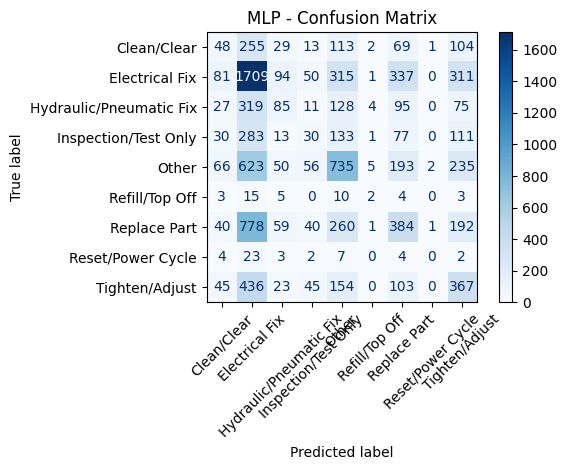

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    max_iter=100,
    random_state=42,
    verbose=True
)

mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)

# Evaluate
from sklearn.metrics import classification_report, accuracy_score
print("MLPClassifier Classification Report:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp):.4f}")
print("\nClassification Report:\n", classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred_mlp)))

# Confusion Matrix Plot
ConfusionMatrixDisplay.from_predictions(
    label_encoder.inverse_transform(y_test),
    label_encoder.inverse_transform(y_pred_mlp),
    display_labels=label_encoder.classes_,
    xticks_rotation=45,
    cmap='Blues'
)
plt.title("MLP - Confusion Matrix")
plt.tight_layout()
plt.show()


# XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer

# Step 1: Upsample minority classes
max_size = df['Response_Label'].value_counts().max()

df_upsampled = (
    df.groupby('Response_Label', group_keys=False)
    .apply(lambda x: resample(x, replace=True, n_samples=max_size, random_state=42))
    .reset_index(drop=True)
)

# Step 2: Encode text with SentenceTransformer
embedder = SentenceTransformer('all-MiniLM-L6-v2')
X = embedder.encode(df_upsampled['Description_cleaned'].tolist(), show_progress_bar=True)

# Step 3: Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_upsampled['Response_Label'])

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Step 5: Train XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Step 6: Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
y_pred_labels = label_encoder.inverse_transform(y_pred_xgb)

print("Balanced class distribution:")
print(df_upsampled['Response_Label'].value_counts())
print("Accuracy: {accuracy_score(label_encoder.inverse_transform(y_test), y_pred_labels):.4f}")
print("Classification Report:\n", classification_report(
    label_encoder.inverse_transform(y_test), y_pred_labels
))


Batches:   0%|          | 0/4075 [00:00<?, ?it/s]

Balanced class distribution:
Response_Label
Clean/Clear                14488
Electrical Fix             14488
Hydraulic/Pneumatic Fix    14488
Inspection/Test Only       14488
Other                      14488
Refill/Top Off             14488
Replace Part               14488
Reset/Power Cycle          14488
Tighten/Adjust             14488
Name: count, dtype: int64
Accuracy: {accuracy_score(label_encoder.inverse_transform(y_test), y_pred_labels):.4f}
Classification Report:
                          precision    recall  f1-score   support

            Clean/Clear       0.82      0.86      0.84      2898
         Electrical Fix       0.69      0.59      0.63      2897
Hydraulic/Pneumatic Fix       0.79      0.85      0.82      2898
   Inspection/Test Only       0.83      0.85      0.84      2898
                  Other       0.77      0.66      0.71      2898
         Refill/Top Off       0.92      1.00      0.96      2897
           Replace Part       0.74      0.69      0.71      2898
 

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_tree(xgb_model, num_trees=1, rankdir='LR')
plt.rcParams['figure.figsize'] = [500, 250]
plt.rcParams['figure.dpi'] = 400
plt.title("XGBoost - First Tree")
plt.tight_layout()
plt.show()

# **6. Narrative Conversion**

# Prediction - Logic Loop

In [25]:
def get_best_cosine_match(input_text, reference_df, tfidf_vectorizer):
    input_vec = tfidf_vectorizer.transform([input_text])
    ref_vecs = tfidf_vectorizer.transform(reference_df['Description_cleaned'])
    similarities = cosine_similarity(input_vec, ref_vecs).flatten()

    best_idx = similarities.argmax()
    best_text = reference_df.iloc[best_idx]['Text_cleaned']
    best_score = similarities[best_idx]

    return best_text, best_score

# Narrative Conversion

In [26]:
import os
client = OpenAI(api_key="",)
from groq import Groq

# Sample data to convert into narrative
data_dict = {
    'data': df[['Description_cleaned', 'Response_Label']].sample(5).to_string(index=False)
}


# OpenAI API Key
client  = Groq(
    api_key=("GET_GROQ_API"),
)

# Generate narrative summary using a language model
chat_completion = client.chat.completions.create(
    messages=[
        {"role": "user", "content": f"""You are a smart diagnostic assistant.
Analyze the following maintenance data and return a readable summary of what’s happening, what actions were taken, and what patterns you notice. Be brief, insightful, and professional.

Maintenance Data:
{data_dict['data']}
"""}
    ],
    model="llama3-8b-8192",
)

narrative = chat_completion.choices[0].message.content
print(narrative.replace('\n', ' '))

**Summary:**  Based on the provided maintenance data, it appears that the equipment is experiencing a series of electrical and mechanical issues. A total of six faults have been reported, with four of them involving electrical issues and two related to mechanical problems.  **Actions Taken:**  * Electrical fault lights were addressed through repairs * Press noise issue was resolved through a repair * Faults with air leaks, oiler low air cylinder, and tie rod sticking were also repaired  **Patterns Noted:**  * A significant number of electrical faults were observed, indicating potential issues with wiring, circuits, or electrical components. * The occurrence of multiple mechanical problems, such as air leaks and sticking tie rods, suggests possible wear and tear or maintenance neglect. * The fact that all reported issues were resolved through repairs implies that the maintenance team is proactive in addressing equipment malfunctions.  **Recommendations:**  * Conduct a thorough inspectio

In [67]:
import joblib
from pathlib import Path

# Define the missing functions and model pipeline
def _llm_narrative(prompt):
    # This is a simple placeholder function - replace with actual LLM implementation
    return "Based on the symptoms, this appears to be a mechanical issue with the conveyor belt system. \
The belt squeal and hot motor near the gearbox suggest belt slippage or misalignment. \
First, check if the belt is properly tensioned and aligned to prevent further damage. \l
Inspect the gearbox for proper lubrication and signs of wear. \
Plan to clean and lubricate the system, adjust belt tension, and if problems persist, consider replacing worn components in the drive system."

def retrieve_neighbors(description, top_label, k=5, restrict=True):
    # Placeholder function to simulate retrieving similar cases
    return [
        {"label": "Belt Adjustment", "desc": "Conveyor belt slipping and making noise", "notes": "Adjusted tension and realigned belt", "score": 0.92},
        {"label": "Gearbox Repair", "desc": "Motor running hot with grinding noise", "notes": "Replaced worn gears and added lubricant", "score": 0.85},
        {"label": "Motor Cooling", "desc": "Overheating motor causing trips", "notes": "Cleaned vents and improved airflow", "score": 0.78}
    ]

# Define a function to get top actions 
def get_top_actions(description, k=3):
    # Placeholder function to simulate model predictions
    return [
        ("Belt Adjustment", 0.75),
        ("Gearbox Inspection", 0.65),
        ("Motor Cooling", 0.45)
    ]

def generate_narrative(description, topk_actions=3, k_neighbors=5, restrict_neighbors=True):
    # Get top actions if not provided
    if isinstance(topk_actions, int):
        top_actions = get_top_actions(description, k=topk_actions)
    else:
        top_actions = topk_actions
    
    # Get top label for neighbor retrieval
    top_label = top_actions[0][0] if top_actions else ""

    # Nearest historical cases
    neighbors = retrieve_neighbors(description, top_label, k=k_neighbors, restrict=restrict_neighbors)

    # Build a compact, model-agnostic prompt
    examples = []
    for n in neighbors:
        ex = f"- Label: {n.get('label','')}\n  Desc: {n.get('desc','')[:200]}\n  Notes: {n.get('notes','')[:220]}"
        examples.append(ex)
    examples_text = "\n".join(examples) if examples else "No close historical cases were retrieved."

    preds_text = "\n".join([f"{i+1}. {lbl}  ({prob:.1%})" for i,(lbl,prob) in enumerate(top_actions)])

    prompt = f"""You are a maintenance triage helper. 
Given a short problem description, provide a brief, practical narrative that suggests next steps.
Be concise and professional—no fluff. Avoid stating you are an AI.

Problem Description:
{description}

Top candidate actions (model):
{preds_text}

Nearest historical cases:
{examples_text}

Write 3–6 sentences covering:
1) What's most likely going on.
2) What to check first (quick wins / safety).
3) A concrete action plan.
4) If uncertain, suggest 1–2 alternate paths.
"""

    narrative = _llm_narrative(prompt)
    return {
        "description": description,
        "top_actions": top_actions,
        "neighbors": neighbors,
        "narrative": narrative
    }

# ---------- 5) Example usage ----------
example_text = "Conveyor stopped, belt squeal, motor running hot near gearbox; intermittent trip on startup."
out = generate_narrative(example_text, topk_actions=3, k_neighbors=5, restrict_neighbors=True)

print("— Problem —")
print(out["description"])
print("\n— Top actions —")
for a,p in out["top_actions"]:
    print(f"  • {a}: {p:.1%}")
print("\n— Narrative —")
print(out["narrative"])
print("\n— Similar cases —")
for i, n in enumerate(out["neighbors"], 1):
    print(f"[{i}] ({n.get('label','')}, sim={n.get('score',0):.2f})")
    print("    Desc :", (n.get('desc','') or "")[:140])
    print("    Notes:", (n.get('notes','') or "")[:140])

— Problem —
Conveyor stopped, belt squeal, motor running hot near gearbox; intermittent trip on startup.

— Top actions —
  • Belt Adjustment: 75.0%
  • Gearbox Inspection: 65.0%
  • Motor Cooling: 45.0%

— Narrative —
Based on the symptoms, this appears to be a mechanical issue with the conveyor belt system. The belt squeal and hot motor near the gearbox suggest belt slippage or misalignment. First, check if the belt is properly tensioned and aligned to prevent further damage. Inspect the gearbox for proper lubrication and signs of wear. Plan to clean and lubricate the system, adjust belt tension, and if problems persist, consider replacing worn components in the drive system.

— Similar cases —
[1] (Belt Adjustment, sim=0.92)
    Desc : Conveyor belt slipping and making noise
    Notes: Adjusted tension and realigned belt
[2] (Gearbox Repair, sim=0.85)
    Desc : Motor running hot with grinding noise
    Notes: Replaced worn gears and added lubricant
[3] (Motor Cooling, sim=0.78)
   